### Objective for Exercise

Use your machine learning skills to build a predictive model to help a business function more efficiently.

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

**Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?**

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance, plot_tree

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

np.random.seed(0)

#from pycaret.classification import *
#from pycaret.clustering import *
from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age,count
0,3478.0,60.0,1.87,2.0,1862.0,100.0,2,3,3478.0,2.00,2,1979
1,4124.0,55.0,1.65,4.8,2500.0,100.0,1,3,2750.0,2.43,89,17
2,7416.0,100.0,2.97,3.0,2500.0,100.0,1,5,7036.0,3.00,62,44
3,2112.0,48.0,0.60,2.0,3500.0,100.0,1,2,2112.0,1.25,89,1101
4,1540.0,30.0,0.96,4.8,1600.0,80.0,1,2,1540.0,2.43,119,58
...,...,...,...,...,...,...,...,...,...,...,...,...
4410,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,2700.0,2.00,129,1
4411,3600.0,45.0,1.80,2.0,2000.0,100.0,1,4,3600.0,2.00,140,264
4412,3720.0,42.0,1.86,2.0,2000.0,100.0,1,3,2716.0,2.00,135,1
4413,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,2700.0,2.00,140,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bldgarea   4415 non-null   float64
 1   bldgdepth  4415 non-null   float64
 2   builtfar   4415 non-null   float64
 3   facilfar   4415 non-null   float64
 4   lotarea    4415 non-null   float64
 5   lotdepth   4415 non-null   float64
 6   numbldgs   4415 non-null   int64  
 7   numfloors  4415 non-null   int64  
 8   resarea    4415 non-null   float64
 9   residfar   4415 non-null   float64
 10  age        4415 non-null   int64  
 11  count      4415 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 414.0 KB


In [5]:
df.describe(include='all')

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age,count
count,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000
mean,5045.138618,53.534297,2.063108,3.642559,2486.385730,97.277619,1.066591,3.160815,4377.229672,2.777178,124.306682,164.407022
std,6281.452795,17.108341,1.159838,1.961428,2570.764718,22.746662,0.349257,1.234769,5964.150780,1.693882,31.312957,449.055041
min,400.000000,1.000000,0.080000,1.000000,375.000000,16.000000,1.000000,1.000000,350.000000,0.500000,1.000000,1.000000
25%,2607.000000,45.000000,1.350000,2.000000,1751.000000,95.000000,1.000000,2.000000,2008.000000,2.000000,113.000000,4.000000
50%,3432.000000,50.000000,1.800000,3.000000,2000.000000,100.000000,1.000000,3.000000,2748.000000,2.430000,127.000000,24.000000
75%,4942.000000,60.000000,2.555000,4.800000,2380.000000,100.440000,1.000000,4.000000,4342.000000,3.440000,139.000000,146.000000
max,65020.000000,200.000000,12.560000,15.000000,64300.000000,962.000000,12.000000,19.000000,65020.000000,10.000000,220.000000,13291.000000


In [6]:
df.shape

(4415, 12)

In [7]:
df.columns

Index(['bldgarea', 'bldgdepth', 'builtfar', 'facilfar', 'lotarea', 'lotdepth', 'numbldgs', 'numfloors', 'resarea', 'residfar', 'age', 'count'], dtype='object')

### Treat Duplicate Values

In [8]:
df.duplicated(keep='first').sum()

26

In [9]:
df[df.duplicated(keep=False)] #Check duplicate values

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age,count
724,2016.0,32.0,1.30,3.0,1550.0,77.50,1,2,1328.0,3.00,121,1
738,2016.0,32.0,1.30,3.0,1550.0,77.50,1,2,1328.0,3.00,121,1
1555,3400.0,50.0,2.00,6.5,1699.0,99.94,1,3,2550.0,3.44,132,1
1560,3400.0,50.0,2.00,6.5,1699.0,99.94,1,3,2550.0,3.44,132,1
2492,2820.0,45.0,1.41,2.0,2003.0,100.20,1,2,1880.0,2.00,122,1
2493,2820.0,45.0,1.41,2.0,2003.0,100.20,1,2,1880.0,2.00,122,1
2563,3074.0,50.0,1.53,2.0,2003.0,100.20,1,2,2009.0,2.00,126,7
2564,3074.0,50.0,1.53,2.0,2003.0,100.20,1,2,2009.0,2.00,126,7
2622,3600.0,45.0,1.80,2.0,2000.0,100.00,1,3,2700.0,2.00,140,8
2698,3600.0,45.0,1.80,3.0,2000.0,100.00,1,3,3600.0,3.00,139,6


In [10]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [11]:
df

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age,count
0,3478.0,60.0,1.87,2.0,1862.0,100.0,2,3,3478.0,2.00,2,1979
1,4124.0,55.0,1.65,4.8,2500.0,100.0,1,3,2750.0,2.43,89,17
2,7416.0,100.0,2.97,3.0,2500.0,100.0,1,5,7036.0,3.00,62,44
3,2112.0,48.0,0.60,2.0,3500.0,100.0,1,2,2112.0,1.25,89,1101
4,1540.0,30.0,0.96,4.8,1600.0,80.0,1,2,1540.0,2.43,119,58
...,...,...,...,...,...,...,...,...,...,...,...,...
4384,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,2700.0,2.00,129,1
4385,3600.0,45.0,1.80,2.0,2000.0,100.0,1,4,3600.0,2.00,140,264
4386,3720.0,42.0,1.86,2.0,2000.0,100.0,1,3,2716.0,2.00,135,1
4387,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,2700.0,2.00,140,2


### Treat Outliers

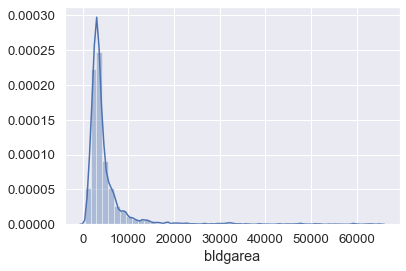

In [13]:
sns.distplot(df.bldgarea);

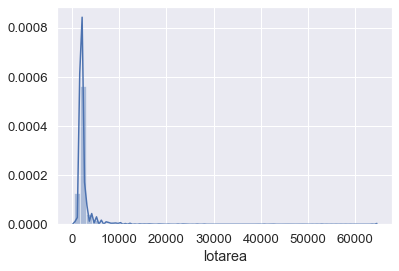

In [14]:
sns.distplot(df.lotarea);

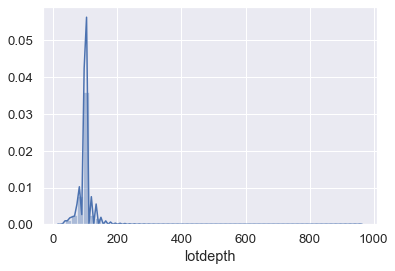

In [15]:
sns.distplot(df.lotdepth);

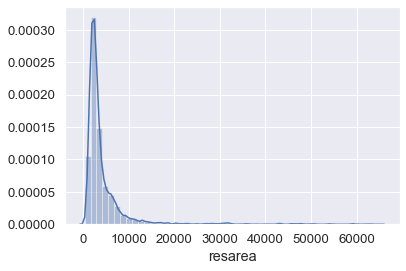

In [16]:
sns.distplot(df.resarea);

In [19]:
windsorizer = Winsorizer(distribution='skewed',tail='right',fold=3, variables=['bldgarea','lotarea', 
                                                                               'lotdepth','resarea'])

In [20]:
windsorizer.fit(df)

Winsorizer(distribution='skewed',
           variables=['bldgarea', 'lotarea', 'lotdepth', 'resarea'])

In [21]:
df2 = windsorizer.transform(df)

In [22]:
df2

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age,count
0,3478.0,60.0,1.87,2.0,1862.0,100.0,2,3,3478.0,2.00,2,1979
1,4124.0,55.0,1.65,4.8,2500.0,100.0,1,3,2750.0,2.43,89,17
2,7416.0,100.0,2.97,3.0,2500.0,100.0,1,5,7036.0,3.00,62,44
3,2112.0,48.0,0.60,2.0,3500.0,100.0,1,2,2112.0,1.25,89,1101
4,1540.0,30.0,0.96,4.8,1600.0,80.0,1,2,1540.0,2.43,119,58
...,...,...,...,...,...,...,...,...,...,...,...,...
4384,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,2700.0,2.00,129,1
4385,3600.0,45.0,1.80,2.0,2000.0,100.0,1,4,3600.0,2.00,140,264
4386,3720.0,42.0,1.86,2.0,2000.0,100.0,1,3,2716.0,2.00,135,1
4387,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,2700.0,2.00,140,2


In [23]:
df2.describe()

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age,count
count,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000
mean,4301.542265,53.572550,2.065906,3.646298,2177.691046,95.595840,1.066758,3.164046,3715.464798,2.780123,124.303030,165.362953
std,2683.991206,17.139401,1.162139,1.963978,765.291628,15.090192,0.349971,1.236770,2640.813698,1.697740,31.394079,450.210944
min,400.000000,1.000000,0.080000,1.000000,375.000000,16.000000,1.000000,1.000000,350.000000,0.500000,1.000000,1.000000
25%,2608.000000,45.000000,1.350000,2.000000,1752.000000,94.940000,1.000000,2.000000,2009.000000,2.000000,113.000000,4.000000
50%,3436.000000,50.000000,1.800000,3.000000,2000.000000,100.000000,1.000000,3.000000,2752.000000,2.430000,127.000000,25.000000
75%,4950.000000,60.000000,2.560000,4.800000,2392.000000,100.440000,1.000000,4.000000,4370.000000,3.440000,139.000000,147.000000
max,11976.000000,200.000000,12.560000,15.000000,4312.000000,116.940000,12.000000,19.000000,11453.000000,10.000000,220.000000,13291.000000


In [24]:
windsorizer.left_tail_caps_

{}

In [25]:
windsorizer.right_tail_caps_

{'bldgarea': 11976.0,
 'lotarea': 4312.0,
 'lotdepth': 116.94,
 'resarea': 11453.0}

In [26]:
#Save as csv
#df2.to_csv("train2.csv",index=False)

### Train Test Split

In [27]:
X = df2.iloc[:,0:11]
y = df2.iloc[:,11]

In [28]:
X.values, y.values

(array([[3.478e+03, 6.000e+01, 1.870e+00, ..., 3.478e+03, 2.000e+00,
         2.000e+00],
        [4.124e+03, 5.500e+01, 1.650e+00, ..., 2.750e+03, 2.430e+00,
         8.900e+01],
        [7.416e+03, 1.000e+02, 2.970e+00, ..., 7.036e+03, 3.000e+00,
         6.200e+01],
        ...,
        [3.720e+03, 4.200e+01, 1.860e+00, ..., 2.716e+03, 2.000e+00,
         1.350e+02],
        [3.600e+03, 4.500e+01, 1.800e+00, ..., 2.700e+03, 2.000e+00,
         1.400e+02],
        [2.960e+03, 4.000e+01, 1.600e+00, ..., 2.220e+03, 2.000e+00,
         1.270e+02]]),
 array([1979,   17,   44, ...,    1,    2,    4], dtype=int64))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3511, 11), (878, 11), (3511,), (878,))

### Feature Scaling

In [31]:
X_train

,bldgarea,bldgdepth,builtfar,facilfar,lotarea,lotdepth,numbldgs,numfloors,resarea,residfar,age
2100,4420.0,100.0,2.21,4.8,2000.0,100.0,1,3,4320.0,2.43,141
1625,11976.0,85.0,4.33,6.5,4312.0,100.0,1,6,11453.0,6.02,107
1969,3100.0,40.0,1.60,2.0,1942.0,100.0,1,3,2400.0,2.00,149
4311,3600.0,45.0,2.25,2.0,1600.0,80.0,1,3,2700.0,2.00,134
3456,11976.0,76.0,2.59,4.8,4312.0,100.0,1,4,11453.0,2.43,97
...,...,...,...,...,...,...,...,...,...,...,...
1033,2160.0,54.0,0.86,2.0,2500.0,100.0,1,2,2160.0,0.75,100
3264,3060.0,45.0,1.80,2.0,1700.0,100.0,1,3,2296.0,2.00,141
1653,11976.0,84.0,4.50,3.0,4312.0,100.0,1,6,11453.0,3.00,114
2607,3600.0,45.0,1.80,2.0,2000.0,100.0,1,3,3600.0,2.00,148


In [32]:
scaler = StandardScaler()

In [33]:
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled

array([[ 0.05601348,  2.75221413,  0.13997368, ...,  0.24570851,
        -0.20028069,  0.53332803],
       [ 2.91221658,  1.8679562 ,  2.03314479, ...,  2.9910485 ,
         1.92916446, -0.55130008],
       [-0.44295265, -0.78481757, -0.40475952, ..., -0.49325865,
        -0.45533958,  0.78853465],
       ...,
       [ 2.91221658,  1.80900568,  2.18495568, ...,  2.9910485 ,
         0.13782063, -0.32799429],
       [-0.25395032, -0.49006493, -0.22615847, ..., -0.03140418,
        -0.45533958,  0.75663382],
       [-0.43388054, -0.19531228, -0.26187868, ..., -0.61565009,
         0.13782063, -0.20039098]])

In [36]:
X_test_scaled

array([[ 0.04845339,  0.09944036,  0.12211357, ..., -0.14686779,
         0.39881112,  0.27812142],
       [-0.61229873, -0.07741123, -0.44940978, ..., -0.39626921,
         0.39881112,  0.18241894],
       [-0.93738272, -0.19531228, -1.02986319, ..., -0.72726492,
        -0.20028069, -0.93411   ],
       ...,
       [-0.27209455, -0.31321334, -0.11006779, ..., -0.50557477,
        -0.20028069, -0.35989512],
       [-0.54879395, -0.49006493, -0.57443052, ..., -0.69339559,
        -0.45533958, -0.13658933],
       [-0.7075559 , -0.19531228, -0.03862737, ..., -0.72418589,
        -0.20028069,  0.69283217]])

### Model Training

### Random Forest Regressor

In [37]:
rf = RandomForestRegressor(random_state=0)

In [38]:
rf.fit(X_train_scaled,y_train)

RandomForestRegressor(random_state=0)

In [39]:
rf_pred = rf.predict(X_test_scaled)

In [40]:
rf_pred[:10]

array([118.28      ,  80.73      ,  99.49207143,  18.06166667,
       182.25666667,  60.3685    , 253.69333333, 436.29616667,
       131.01719048, 211.27666667])

### Model Evaluation

In [41]:
mse = mean_squared_error(y_test,rf_pred)
mse

354043.1408204935

In [42]:
rmse = np.sqrt(mse)
rmse

595.0152441916875

In [43]:
r2score = r2_score(y_test,rf_pred)
r2score

-0.12546430831647126

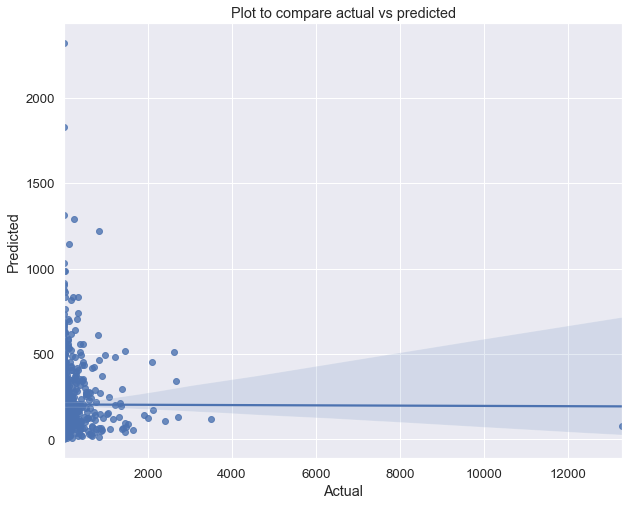

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=rf_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

In [45]:
rf.feature_importances_

array([0.12986064, 0.0863876 , 0.17290243, 0.03268872, 0.11131659,
       0.07876256, 0.00462001, 0.02438925, 0.16518615, 0.04095756,
       0.15292849])

Load the feature importances into a pandas series indexed by your column names, then use its plot method. e.g. for an sklearn RF classifier/regressor model trained using df: 

In [46]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)

In [47]:
feat_importances

bldgarea     0.129861
bldgdepth    0.086388
builtfar     0.172902
facilfar     0.032689
lotarea      0.111317
lotdepth     0.078763
numbldgs     0.004620
numfloors    0.024389
resarea      0.165186
residfar     0.040958
age          0.152928
dtype: float64

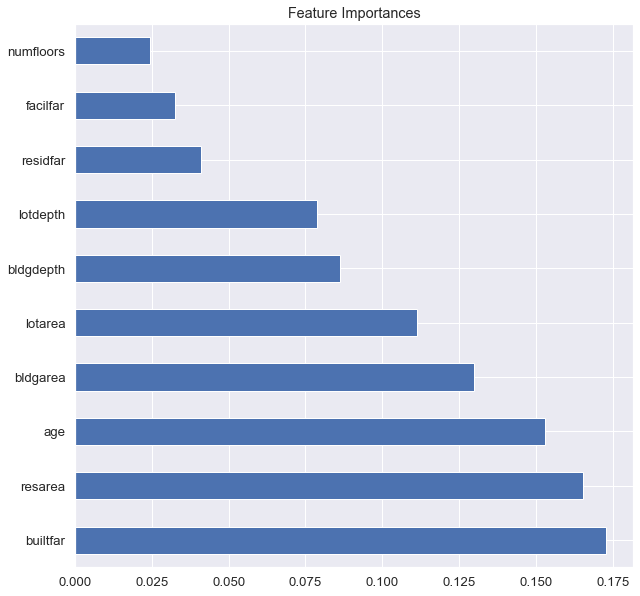

In [48]:
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,10))
plt.title('Feature Importances')
plt.show()

### The permutation based importance

In [49]:
perm_importance = permutation_importance(rf,X_test,y_test, random_state=0, scoring='neg_mean_squared_error')

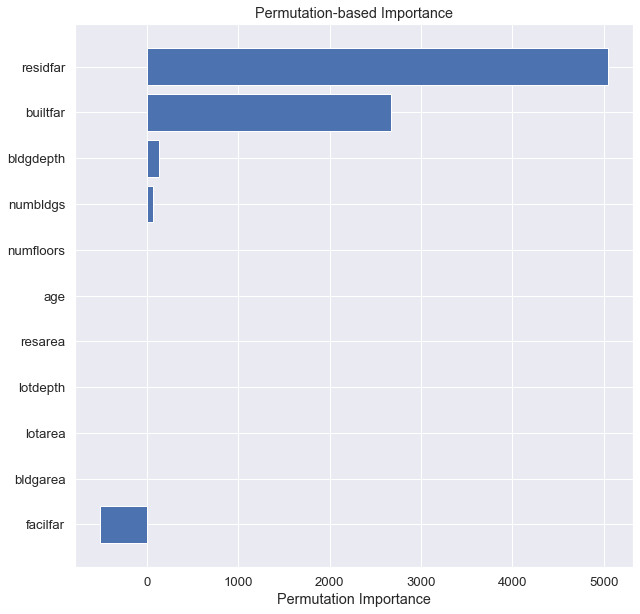

In [50]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,10))
plt.title("Permutation-based Importance")
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [51]:
perm_importance.importances_mean.argsort()

array([ 3,  0,  4,  5,  8, 10,  7,  6,  1,  2,  9], dtype=int64)

### Compute Importance from SHAP Values

In [52]:
explainer = shap.TreeExplainer(rf)

In [53]:
shap_values = explainer.shap_values(X_test)

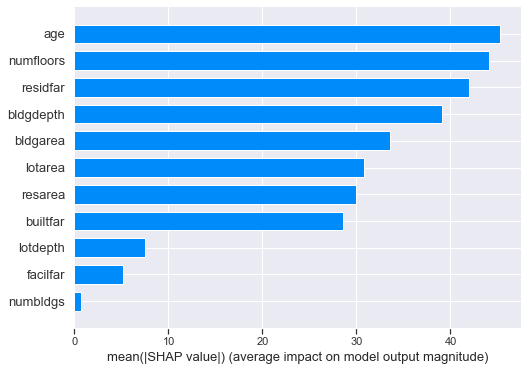

In [54]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

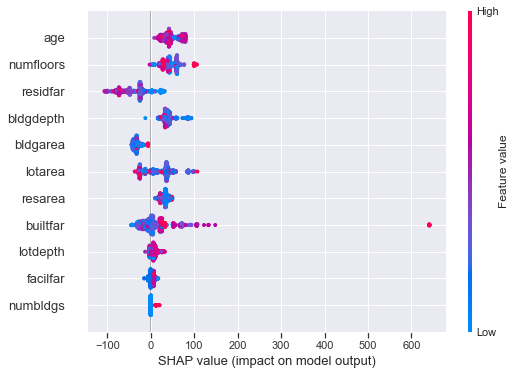

In [55]:
shap.summary_plot(shap_values, X_test)

### Using XGBoost (Scikit-Learn)

### Using RandomSearchCV

In [56]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [57]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,10,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1),
              'reg_alpha':np.arange(0,1,0.1),
              'reg_lambda':np.arange(0,1,0.1)
             }

In [58]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 10, 
                           n_jobs=-1, scoring='neg_mean_squared_error')

In [59]:
randm.fit(X_train_scaled, y_train)

[12:46:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                        'learning rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
           

In [60]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=2,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning rate=0.1, learning_rate=0.300000012, max_delta_step=0,
             max_depth=4, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0.1, reg_lambda=0.4,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [61]:
randm.best_score_

-230002.7735839106

In [62]:
randm.best_params_

{'subsample': 0.7,
 'reg_lambda': 0.4,
 'reg_alpha': 0.1,
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.7999999999999999}

### Final Model

In [63]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror',
                       subsample=0.7,reg_lambda=0.4,reg_alpha=0.1, min_child_weight=2,
                       max_depth=4,learning_rate=0.1,gamma=2,colsample_bytree=0.8)

In [64]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:581.16949
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:577.41956
[2]	validation_0-rmse:574.34070
[3]	validation_0-rmse:571.89447
[4]	validation_0-rmse:570.37207
[5]	validation_0-rmse:568.44763
[6]	validation_0-rmse:566.30102
[7]	validation_0-rmse:564.98608
[8]	validation_0-rmse:563.79584
[9]	validation_0-rmse:563.10999
[10]	validation_0-rmse:562.66553
[11]	validation_0-rmse:562.31842
[12]	validation_0-rmse:561.70868
[13]	validation_0-rmse:561.21704
[14]	validation_0-rmse:560.95245
[15]	validation_0-rmse:560.38721
[16]	validation_0-rmse:560.18939
[17]	validation_0-rmse:559.99323
[18]	validation_0-rmse:560.13062
[19]	validation_0-rmse:560.02460
[20]	validation_0-rmse:560.05023
[21]	validation_0-rmse:560.13751
[22]	validation_0-rmse:560.14557
[23]	validation_0-rmse:560.79010
[24]	validation_0-rmse:560.72162
[25]	validation_0-rmse:560.86694
[26]	validation_0-rmse:560.75458
[27]	validation_0-rmse:560.48291
Stopping. Best iterat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=0.4, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
y_pred = xgbmodel.predict(X_test_scaled)

In [66]:
y_pred

array([115.54847 , 166.31055 , 145.09831 ,  79.259674, 148.02193 ,
       132.56909 , 127.13591 , 212.13889 , 127.82784 , 199.47765 ,
       156.6543  , 107.54765 , 133.5453  , 127.08834 , 123.64424 ,
       165.04895 , 133.10078 , 353.06223 , 140.4309  , 225.70865 ,
       114.20239 , 155.89034 , 166.02477 , 169.40277 , 169.80363 ,
       124.06277 , 104.07128 , 122.540146, 174.56303 , 149.26144 ,
       141.9219  , 140.03075 , 133.26784 , 173.45462 , 133.49704 ,
        99.53059 , 140.03075 , 128.83746 , 133.49704 , 118.260735,
       133.95956 , 134.25624 , 129.84258 , 114.236084, 141.58218 ,
       155.89034 , 172.46188 , 129.79912 , 116.38448 , 128.00816 ,
       231.91997 , 180.08775 , 222.60959 , 142.12833 , 146.67096 ,
       275.46243 ,  74.811195, 125.615746, 139.50092 ,  86.8762  ,
       153.88533 , 142.12833 , 122.46012 , 187.49335 , 122.78533 ,
       155.26237 , 148.72475 , 125.63329 , 146.25409 , 147.40472 ,
       123.39206 ,  96.99566 , 196.79094 , 120.68408 , 121.747

### Model Evaluation

In [67]:
mse = mean_squared_error(y_test,y_pred)
mse

313592.4101101216

In [68]:
rmse = np.sqrt(mse)
rmse

559.993223271605

In [69]:
r2score = r2_score(y_test,y_pred)
r2score

0.003124127415791933

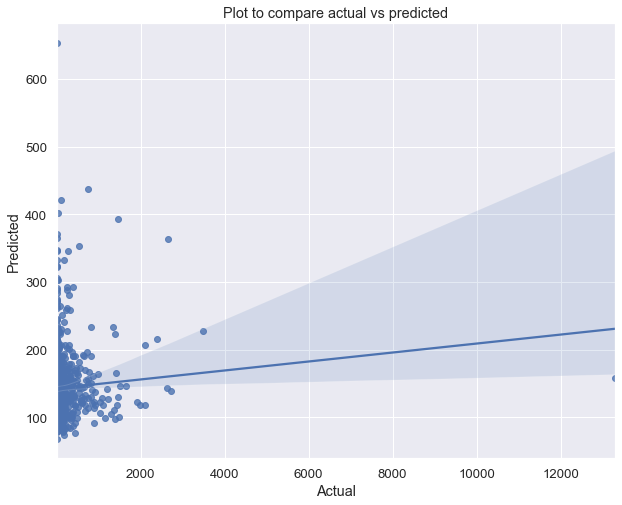

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [73]:
X.columns

Index(['bldgarea', 'bldgdepth', 'builtfar', 'facilfar', 'lotarea', 'lotdepth', 'numbldgs', 'numfloors', 'resarea', 'residfar', 'age'], dtype='object')

In [74]:
xgbmodel.get_booster().feature_names = ['bldgarea', 'bldgdepth', 'builtfar', 'facilfar', 'lotarea', 'lotdepth', 'numbldgs', 'numfloors', 'resarea', 'residfar', 'age']

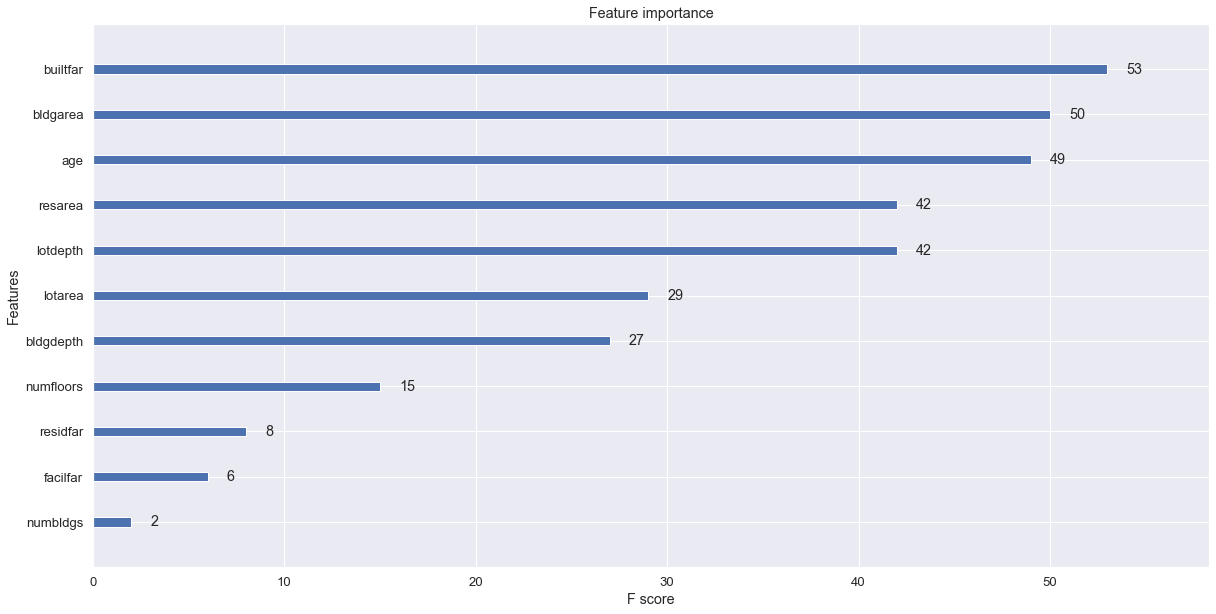

In [75]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

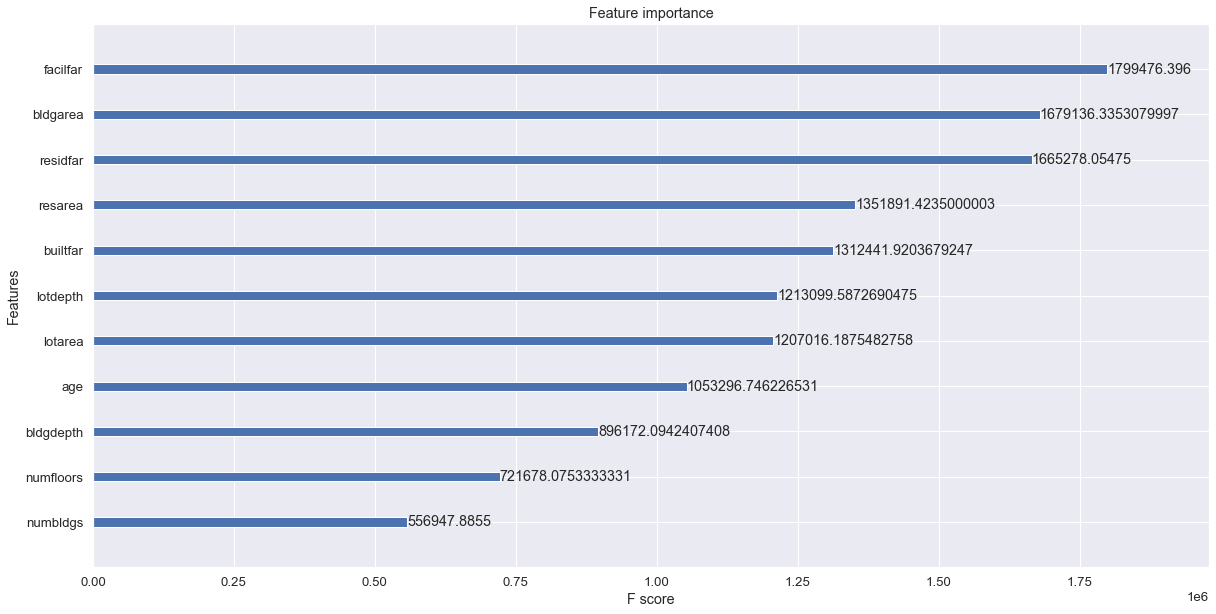

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgbmodel, importance_type='gain', ax=ax)
plt.show()

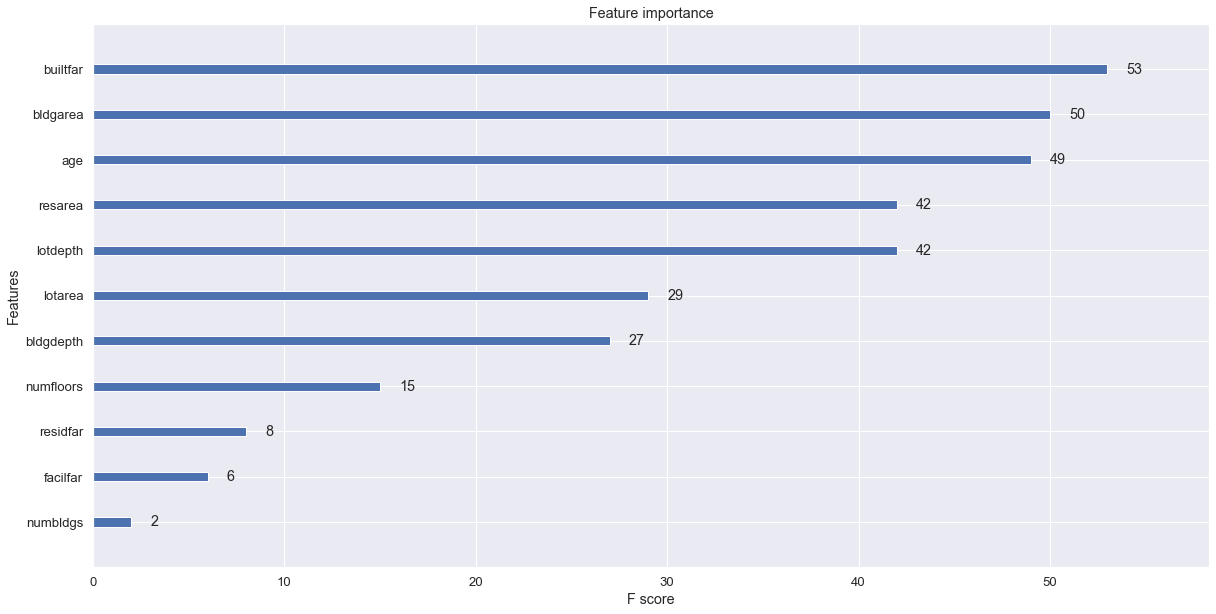

In [80]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgbmodel, importance_type='weight', ax=ax)
plt.show()

### Cross-Validation

In [81]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


In [82]:
cv.mean()

-0.18458769299863578

### Save the Model

In [83]:
filename = 'complainmodel2.sav'
dump(xgbmodel,open(filename,'wb'))

### Load the Model

In [84]:
loaded_model = load(open(filename,'rb'))

In [85]:
loaded_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=0.4, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)